# data prepare

In [5]:
import pandas as pd
from PIL import Image
import torch

In [2]:
data = pd.read_csv('./data/list_attr_celeba.txt', sep="\s*", header=0)
partition = pd.read_csv('./data/list_eval_partition.txt', sep="\s*", header=None)

/home/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/home/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2379: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/home/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2381: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/home/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [3]:
partition.columns = ["filename", "file_cate"]
data = data.merge(partition, on = "filename", how = "left")

In [4]:
print(data.columns)

Index(['filename', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young', 'file_cate'],
      dtype='object')


In [5]:
data.to_csv("./data/list_merge_attr_celeba.csv", index = False)

In [16]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')#将图片转换为RGB格式。

In [7]:
picture_data1=pil_loader(r'/home/tongqing.li/qianbao/picture_score/data/img_align_celeba/000001.jpg')

In [17]:
import numpy as np
np.array(picture_data1).shape

NameError: name 'picture_data1' is not defined

In [6]:
from torch.utils.data import Dataset, DataLoader 
import os
class myDataset(Dataset):
    def __init__(self, loadPath, transform, data_category = 0): #r'home/tongqing.li/lesson/pytorch/MNIST_data/MNIST/processed/training.pt'
        super(myDataset, self).__init__()
        self.data = pd.read_csv(loadPath)
        self.data = self.data[self.data["file_cate"] == data_category]
        self.transform = transform
        
    def __getitem__(self, index):
        #Heavy_Makeup，Male，Wearing_Earrings，Wearing_Necklace，Wearing_Necktie
        picture = pil_loader(r'/home/tongqing.li/qianbao/picture_score/data/img_align_celeba/' + self.data.iloc[index]["filename"])
        label = self.data.iloc[index][["Eyeglasses", "Heavy_Makeup", "Male", "Wearing_Earrings", "Wearing_Necktie", 'Attractive', 'Wearing_Hat']]
        for i in ["Eyeglasses", "Heavy_Makeup", "Male", "Wearing_Earrings", "Wearing_Necktie", 'Attractive', 'Wearing_Hat']:
            if (label.loc[i] == -1):
                label.loc[i] = 0
        label = torch.tensor(label)
        picture = self.transform(picture)
        return (picture, label.long())
    
    def __len__(self):
        return self.data.shape[0]

In [7]:
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.Resize((224,224)), transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_face_dataset = myDataset("./data/list_merge_attr_celeba.csv", data_category = 0, transform = transform)
valid_face_dataset = myDataset("./data/list_merge_attr_celeba.csv", data_category = 1, transform = transform)
test_face_dataset = myDataset("./data/list_merge_attr_celeba.csv", data_category = 2, transform = transform)

In [25]:
print(valid_face_dataset.__len__())
print(test_face_dataset.__len__())

19867
19962


In [13]:
train_face_dataset.__getitem__(0)[1].shape

torch.Size([7])

In [8]:
batch_size = 64
num_workers = 4

In [9]:
train_face_loader = DataLoader(train_face_dataset, batch_size=batch_size, shuffle=True,num_workers=num_workers, pin_memory=True)
valid_face_loader = DataLoader(valid_face_dataset, batch_size=batch_size, shuffle=True,num_workers=num_workers, pin_memory=True)
test_face_loader = DataLoader(test_face_dataset, batch_size=batch_size, shuffle=True,num_workers=num_workers, pin_memory=True)

In [38]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo


__all__ = ['ResNet', 'resnet50']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class fc_block(nn.Module):
    def __init__(self, inplanes, planes, drop_rate=0.15):
        super(fc_block, self).__init__()
        self.fc = nn.Linear(inplanes, planes)
        self.bn = nn.BatchNorm1d(planes)
        if drop_rate > 0:
            self.dropout = nn.Dropout(drop_rate)
        self.relu = nn.ReLU(inplace=True)
        self.drop_rate = drop_rate

    def forward(self, x):
        x = self.fc(x)
        x = self.bn(x)
        if self.drop_rate > 0:
            x = self.dropout(x)
        x = self.relu(x)
        return x


class ResNet(nn.Module):

    def __init__(self, block, layers, num_attributes=7, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.stem = fc_block(512 * block.expansion, 512)
        for i in range(num_attributes):
            setattr(self, 'classifier' + str(i).zfill(2), nn.Sequential(fc_block(512, 256), nn.Linear(256, 2)))
        self.num_attributes = num_attributes

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.stem(x)

        y = []
        for i in range(self.num_attributes):
            classifier = getattr(self, 'classifier' + str(i).zfill(2))
            y.append(classifier(x))

        return y


def resnet50(pretrained=True, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        init_pretrained_weights(model, model_urls['resnet50'])
    return model

def resnet18(pretrained=True, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], num_attributes = 5, **kwargs)
    
    if pretrained:
        init_pretrained_weights(model, model_urls['resnet18'])
    return model

def init_pretrained_weights(model, model_url):
    """
    Initialize model with pretrained weights.
    Layers that don't match with pretrained layers in name or size are kept unchanged.
    """
    pretrain_dict = model_zoo.load_url(model_url)
    model_dict = model.state_dict()
    pretrain_dict = {k: v for k, v in pretrain_dict.items() if k in model_dict and model_dict[k].size() == v.size()}
    model_dict.update(pretrain_dict)
    model.load_state_dict(model_dict)
    print("Initialized model with pretrained weights from {}".format(model_url))



In [365]:
print(len(train_face_loader))

2544


In [82]:
amount = [0, 0, 0, 0, 0, 0, 0]
for images, labels in test_face_loader:
    for i in labels:
        for j, k in enumerate(i):
            if k == 1:
                amount[j] = amount[j] + 1
print(amount)

[1289, 8084, 7715, 4125, 1399, 9898, 839]


In [13]:
from torch import nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = resnet50()

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
epochs = 100
steps = 0

train_losses, test_losses = [], []
for e in range(2, epochs):
    running_loss = 0
    j = 0
    for images, labels in train_face_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        model_output = model(images)
        loss = []
        for i, model_output_data in enumerate(model_output):
            if i >=3:
                loss.append(5 * criterion(model_output_data, labels[:,i]))
            else:
                loss.append(criterion(model_output_data, labels[:,i]))
        #print(loss)
        sum(loss).backward()
        optimizer.step()
        
        running_loss += sum(loss).item()
        
        if (j % 250 == 0):
            print(sum(loss)/7, j)
            torch.save(model.state_dict(), r'/home/tongqing.li/qianbao/deep_learning/neural_network_in_pytorch/deep_model/model' + str(e + 1) + ' ' + str(j))
        j = j + 1
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()#这里就是关闭dropout了。
            accuracy = [0, 0, 0, 0, 0, 0, 0]
            test_loss = []
            for images, labels in valid_face_loader:
                images, labels = images.to(device), labels.to(device)
                log_ps = model(images)
                
                for i, log_ps_data in enumerate(log_ps):
                    #print(criterion(log_ps_data, labels[:,i]))
                    test_loss.append(criterion(log_ps_data, labels[:,i]))
                    top_p, top_class = log_ps_data.topk(1, dim=1)
                    equals = top_class == labels[:, i].view(*top_class.shape)
                    accuracy[i] += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        for i in range(7):
            accuracy[i] = accuracy[i] / len(valid_face_loader)
        #model.load_state_dict(torch.load(filepath))
        torch.save(model.state_dict(), r'/home/tongqing.li/qianbao/deep_learning/neural_network_in_pytorch/deep_model/model' + str(e + 1))
        train_losses.append(running_loss/len(train_face_loader))
        test_losses.append(sum(test_loss)/len(valid_face_loader))
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.6f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.4f}".format(sum(accuracy)/5))
        print(accuracy)

Initialized model with pretrained weights from https://download.pytorch.org/models/resnet50-19c8e357.pth


KeyboardInterrupt: 

In [ ]:
#Epoch: 1/100..  Training Loss: 1.122..  Test Loss: 0.496323..  Test Accuracy: 0.9589
#[tensor(0.9960), tensor(0.9198), tensor(0.9874), tensor(0.9250), tensor(0.9663)]

In [95]:
model = resnet50()
model.load_state_dict(torch.load(r'/home/tongqing.li/qianbao/deep_learning/neural_network_in_pytorch/deep_model/model2'))
model.to(device)

Initialized model with pretrained weights from https://download.pytorch.org/models/resnet50-19c8e357.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
"model3"

In [53]:
        with torch.no_grad():    
            model.eval()#这里就是关闭dropout了。
            accuracy = [0, 0, 0, 0, 0, 0, 0]
            test_loss = []
            for images, labels in test_face_loader:
                images, labels = images.to(device), labels.to(device)
                log_ps = model(images)
                x = 0
                #print(len(log_ps))
                for i, log_ps_data in enumerate(log_ps):
                    #print(criterion(log_ps_data, labels[:,i]))
                    test_loss.append(criterion(log_ps_data, labels[:,i]))
                    top_p, top_class = log_ps_data.topk(1, dim=1)
                    equals = top_class == labels[:, i].view(*top_class.shape)
                    accuracy[i] += torch.mean(equals.type(torch.FloatTensor))
                #print(accuracy)
            model.train()

In [54]:
tot = 0
for i in range(7):
    print(accuracy[i]/len(test_face_loader))
    tot = tot + accuracy[i]/len(test_face_loader)
print(tot/7)
#"Eyeglasses", "Heavy_Makeup", "Male", "Wearing_Earrings", "Wearing_Necklace", "Wearing_Necktie"

tensor(0.9947)
tensor(0.9069)
tensor(0.9585)
tensor(0.8898)
tensor(0.9654)
tensor(0.8057)
tensor(0.9906)
tensor(0.9302)


In [96]:
test_output = []
y_true = []
#test_output.to(device)
for i in range(7):
    test_output.append(torch.Tensor())
    y_true.append(torch.Tensor())
with torch.no_grad():    
    model.eval()#这里就是关闭dropout了。
    accuracy = [0, 0, 0, 0, 0, 0]
    for images, labels in test_face_loader:
        images, labels = images.to(device), labels.to(device)
        log_ps = model(images)
        for i in range(7):
            #print(labels[:, :i+1].shape)
            y_true[i] = torch.cat((y_true[i].to(device), labels[:, i:i+1].type(torch.FloatTensor).to(device)))
            #print(type(y_true[i]))
        for i, log_ps_data in enumerate(log_ps):
            test_output[i] = torch.cat((test_output[i].to(device), log_ps_data))
        #print(test_output[0].shape)

In [97]:
softmax = nn.Softmax()
test_output[0].shape
for i in range(len(test_output)):
    for j in range(len(test_output[i])):
        #print(test_output[i][j].shape)
        test_output[i][j] = softmax(test_output[i][j])
        #print(j)

print(test_output[0].shape, len(test_output))    

/home/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


torch.Size([19962, 2]) 7


In [42]:
a = y_true
b = test_output

In [88]:
print(len(b))

5


In [98]:
from sklearn.metrics import precision_recall_curve
for i in range(7):
    y_true[i] = y_true[i].squeeze(1).cpu().detach().numpy()
    test_output[i] = test_output[i][:, 1:2].squeeze(1).cpu().detach().numpy()

In [93]:
print(test_output[4].shape, y_true[4].shape)

(19962,) (19962,)


In [75]:
from sklearn.metrics import precision_recall_curve
pr = []
for i, output in enumerate(test_output):
    pr.append(precision_recall_curve(y_true[i], output))

In [79]:
locs = [0, 0, 0, 0, 0]
areas = [0, 0, 0, 0, 0]
for i in range(7):
    index = 0
    for j in pr[i][0]:
        areas[i] = areas[i] + j
        if (j > 0.85 and locs[i] == 0):
            locs[i] = index
        index = index + 1
print(locs)
for i, j in enumerate(locs):
    print(pr[i][0][j], pr[i][1][j], pr[i][2][j])
for i, j in enumerate(areas):
    print(j , len(pr[i][0]))

[14491, 5380, 4435, 13826, 6281]
0.8503674014696059 0.9875872769588828 0.04909164
0.8500224014336918 0.9387679366650173 0.46291822
0.8500883782589483 0.9974076474400518 0.04306442
0.8501111463956812 0.648969696969697 0.71265244
0.8503803888419273 0.7190850607576841 0.52369654
4497.325897275052 15974
12235.8239093053 14128
9537.962243010206 11026
9266.130237179643 16972
3517.0406462971478 7465


In [99]:
from sklearn.metrics import average_precision_score
for i in range(7):
    print(average_precision_score(y_true[i], test_output[i]))

0.9890952466311095
0.9656164207896252
0.9968486969304124
0.8591745047666501
0.8784694836665125
0.9172518997082013
0.9507589526563246


In [44]:
#"Eyeglasses"
#"Heavy_Makeup"
#Male"
#"Wearing_Earrings"
#"Wearing_Necktie"
#"Attractive"
#"Wearing_hat"

0.9504504504504504 0.9821567106283942
0.9500826943316795 0.7816674913409203
0.9500688274308597 0.9840570317563189
0.9503149055283415 0.32921212121212123
0.95 0.4481772694781987
0.95 0.5298040008082441
0.9502196193265008 0.7735399284862932


In [ ]:
resnet50
[7500, 6547, 5467, 13262, 10260, 10620, 7055]
0.8501997336884154 0.9906904577191621 0.1966078
0.8500899685110211 0.9350569025235033 0.4980192
0.8500664893617021 0.9942968243681141 0.0068693478
0.8501125763911226 0.6407272727272727 0.78052384
0.8505647263249348 0.6997855611150822 0.7454451
0.8500420218513627 0.7152960193978581 0.56106395
0.8506981740064447 0.9439809296781884 0.14616553
0.4181861446886388
0.8397619267180813
0.8614367181298155
0.5543513970982502
0.3582113636125652
0.8003367630104347
0.33590372562092385
resnet18
[14491, 5380, 4435, 13826, 6281]
0.8503674014696059 0.9875872769588828 0.04909164
0.8500224014336918 0.9387679366650173 0.46291822
0.8500883782589483 0.9974076474400518 0.04306442
0.8501111463956812 0.648969696969697 0.71265244
0.8503803888419273 0.7190850607576841 0.52369654
0.28154037168367674
0.8660690762532064
0.8650428299483227
0.5459657222000732
0.4711373940116742

In [ ]:
#3x and 2x loss
0.9506357516828721 0.9860356865787432
0.95 0.7897080653142009
0.9501125281320331 0.9849643551523007
0.9502164502164502 0.31927272727272726
0.9504249291784702 0.47962830593280914
#5x loss
0.9505988023952096 0.9852598913886734
0.95 0.7685551707075705
0.9500436028404136 0.9884640311082307
0.9501639344262295 0.3512727272727273
0.95 0.5025017869907077
#resnet18
0.9503012048192772 0.9790535298681148
0.9500523403618962 0.7858733300346363
0.9500748876684972 0.986649384316267
0.9500947567909034 0.3646060606060606
0.9511450381679389 0.4453180843459614

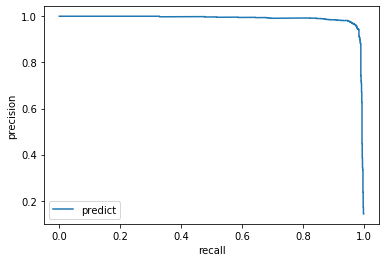

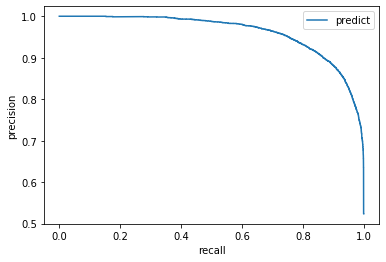

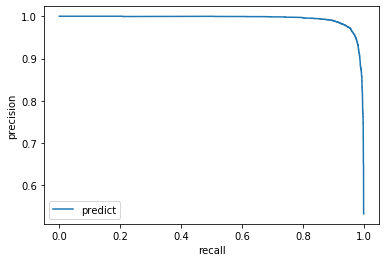

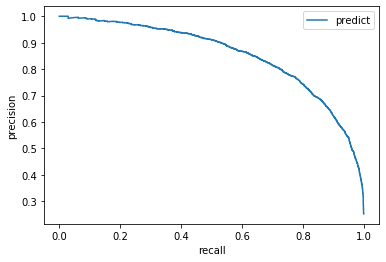

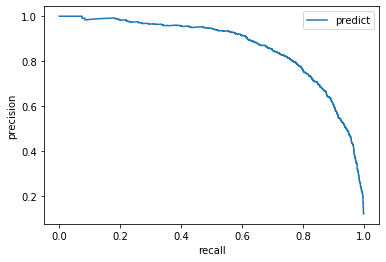

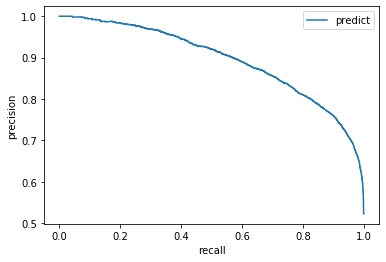

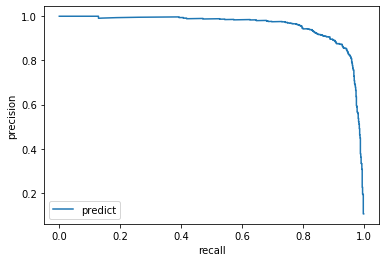

In [67]:
import matplotlib.pyplot as plt
#plt.plot(x,y,label="fact")
for i in range(7):
    plt.plot(pr[i][1],pr[i][0],label="predict")
    plt.title("")
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend()
    plt.savefig(fname="result.png",figsize=[10,10])
    plt.show()
    #"Eyeglasses", "Heavy_Makeup", "Male", "Wearing_Earrings", "Wearing_Necklace", "Wearing_Necktie"

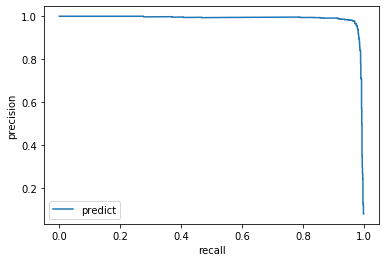

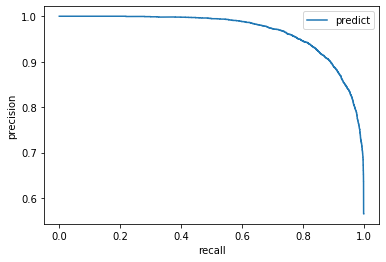

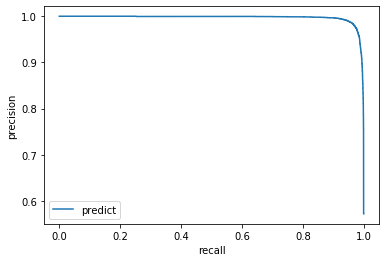

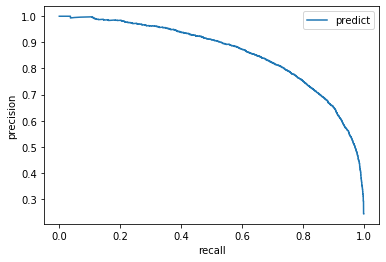

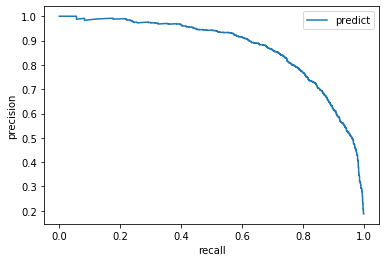

In [78]:
#resnet18
for i in range(5):
    plt.plot(pr[i][1],pr[i][0],label="predict")
    plt.title("")
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend()
    plt.savefig(fname="result.png",figsize=[10,10])
    plt.show()